In [1]:

# import packages from env
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# Function for calculating psnr

def cal_psnr(gray,segm):
    summed_error = 0
    m,n = np.shape(gray)

    diff_mat = gray - segm
    sq_diff_mat = diff_mat * diff_mat
    summed_error = np.sum(sq_diff_mat.flatten())
    
    number_pixels = m*n
    mean_square_error = summed_error/number_pixels
    rmse =  np.sqrt(mean_square_error)
    psnr = 20*np.log10(255/rmse)

    return psnr

In [3]:

def cal_variance(a,b,freq,intensity):
    a = int(a)
    b = int(b)

    b+=1 # python index thing
    sum1 = np.sum(freq[a:b]*intensity[a:b])
    sum2 = np.sum(freq[a:b]*intensity[a:b]*intensity[a:b])
    sum3 = np.sum(freq[a:b])
    
    variance = sum2/sum3 - (sum1/sum3)**2
    return variance

In [17]:
def mode(a,b,freq,intensity):
    # trying mode insteda
    a=int(a)
    b=int(b)
    print(a,b)
    if a<b:
        return intensity[a:b+1][np.argmax(freq[a:b+1])]
    elif(a==b):
        return intensity[a-1]
    else:
        return intensity[b:a+1][np.argmax(freq[b:a+1])]


In [12]:
def wt_mean(a,b,freq,intensity):
    
    return mode(a,b,freq,intensity)
    # original mean calculation
    a=int(a)
    b=int(b)
    sum1 = np.sum(freq[a:b+1]*intensity[a:b+1])
    sum2 = np.sum(freq[a:b+1])
    value = sum1/sum2
    return int(value)

In [13]:

def assign_val(mat, hh, hl, ll, lh, high_assign, low_assign):
    hl = int(hl)
    lh = int(lh)
    mat2 = mat.copy()  # Avoid modifying original matrix
    
    
    # print(hh, hl, ll, lh, high_assign, low_assign)
    
    # Apply high assignment: hl ≤ mat ≤ hh
    high_mask = (mat2 >= hl) & (mat2 <= hh)
    mat2[high_mask] = high_assign

    # Apply low assignment: ll ≤ mat2 ≤ lh
    low_mask = (mat2 >= ll) & (mat2 <= lh)
    mat2[low_mask] = low_assign
    
    mat2 = mat2.astype(np.int16)
    
    return mat2

In [14]:
def thresh_mean(first, last, freq, intensity, im):
    mean3 = wt_mean(first, last, freq, intensity)
    
    mean4 = wt_mean(mean3 + 1, last, freq, intensity)
    mean5 = wt_mean(first, mean3, freq, intensity)

    im = assign_val(im, hh=last, hl=mean3 + 1, ll=first, lh=mean3,high_assign=mean4, low_assign=mean5)

    return mean4, mean5, mean3, im

In [15]:
def thresh_var(first,last,freq,intensity,im):
    mean1=wt_mean(first,last,freq,intensity)
    sum_par=cal_variance(first,last,freq,intensity)
    std=np.sqrt(sum_par)
    high=np.floor(mean1+std) 
    low=np.floor(mean1-std)
    
    if high>last:
        high=last
    if low<first:
        low=first
        
    high_assign=wt_mean(high,last,freq,intensity)
    low_assign=wt_mean(first,low,freq,intensity)
    
    im=assign_val(im,last,high,first,low,high_assign,low_assign)
    
    first=low+1
    last=high-1
    
    high_assign = int(high_assign)
    low_assign = int(low_assign)
    
    return(high_assign,low_assign,first,last,im)

### Matlab algorithm

**rgb2gray** used in original MATLAB code converts RGB values to grayscale values by forming a weighted sum of the R, G, and B components:

0.298936021293775 * R + 0.587043074451121 * G + 0.114020904255103 * B

The coefficients used to calculate grayscale values in rgb2gray are identical to those used to calculate luminance (E'y) in Rec.ITU-R BT.601-7 after rounding to 3 decimal places. Rec.ITU-R BT.601-7 calculates E'y using this formula:

0.299 * R + 0.587 * G + 0.114 * B


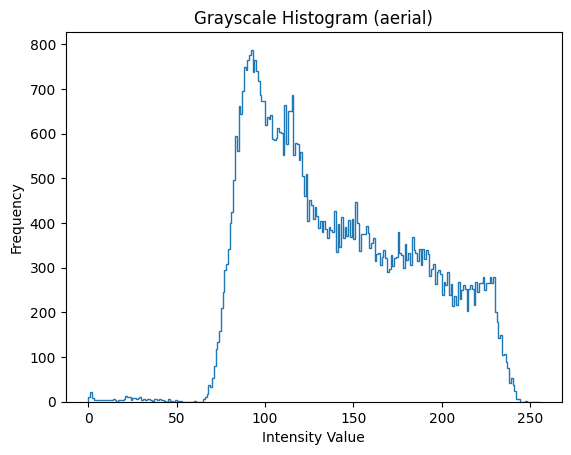

0 255
93 255
0 92
0 255
137 255
0 46
47 136
93 136
47 92
0 255
137 255
0 46
47 136
108 136
47 75
76 107
93 107
76 92
0 255
137 255
0 46
47 136
108 136
47 75
76 107
100 107
76 83
84 99
93 99
84 92
0 255
137 255
0 46
47 136
108 136
47 75
76 107
100 107
76 83
84 99
96 99
84 87
88 95
93 95
88 92


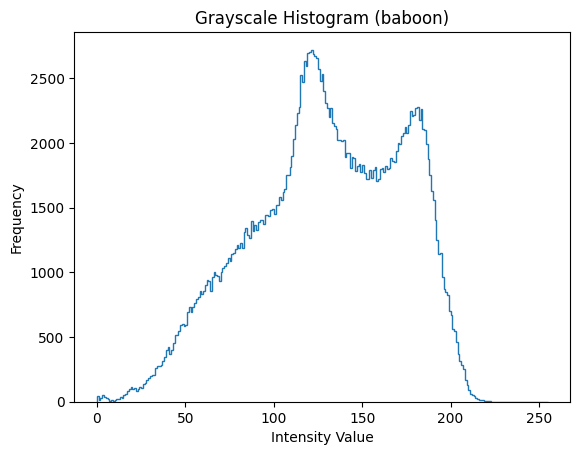

0 255
122 255
0 121
0 255
163 255
0 78
79 162
122 162
79 121
0 255
163 255
0 78
79 162
143 162
79 98
99 142
122 142
99 121
0 255
163 255
0 78
79 162
143 162
79 98
99 142
132 142
99 109
110 131
122 131
110 121
0 255
163 255
0 78
79 162
143 162
79 98
99 142
132 142
99 109
110 131
127 131
110 114
115 126
122 126
115 121


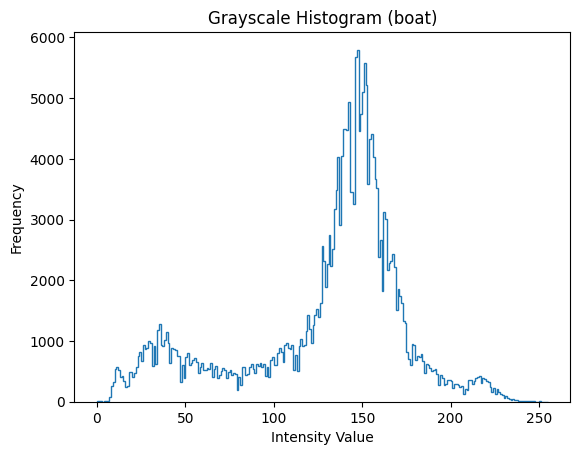

0 255
148 255
0 147
0 255
193 255
0 100
101 192
148 192
101 147
0 255
193 255
0 100
101 192
165 192
101 128
129 164
148 164
129 147
0 255
193 255
0 100
101 192
165 192
101 128
129 164
156 164
129 137
138 155
148 155
138 147
0 255
193 255
0 100
101 192
165 192
101 128
129 164
156 164
129 137
138 155
152 155
138 141
142 151
148 151
142 147


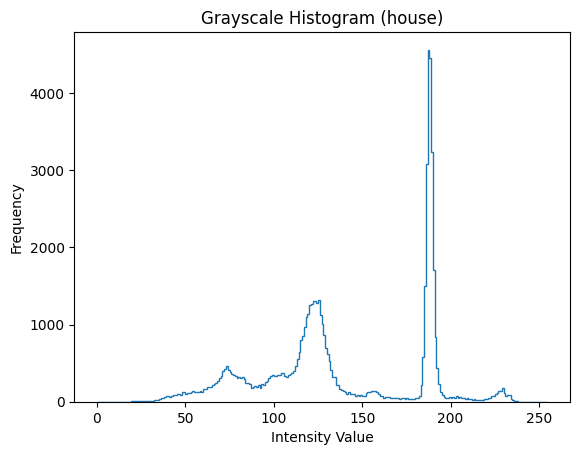

0 255
188 255
0 187
0 255
233 255
0 140
141 232
188 232
141 187
0 255
233 255
0 140
141 232
201 232
141 172
173 200
188 200
173 187
0 255
233 255
0 140
141 232
201 232
141 172
173 200
189 200
173 184
185 188
188 188
185 187
0 255
233 255
0 140
141 232
201 232
141 172
173 200
189 200
173 184
185 188
187 188
185 186
187 186
188 186
187 187


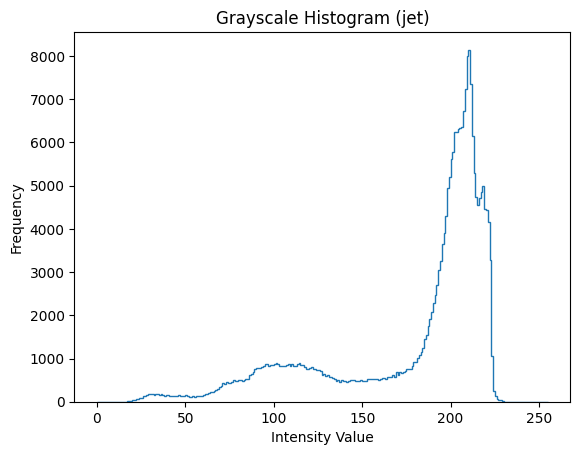

0 255
211 255
0 210
0 255
255 255
0 163
164 254
211 254
164 210
0 255
255 255
0 163
164 254
222 254
164 197
198 221
211 221
198 210
0 255
255 255
0 163
164 254
222 254
164 197
198 221
216 221
198 203
204 215
211 215
204 210
0 255
255 255
0 163
164 254
222 254
164 197
198 221
216 221
198 203
204 215
213 215
204 206
207 212
211 212
207 210


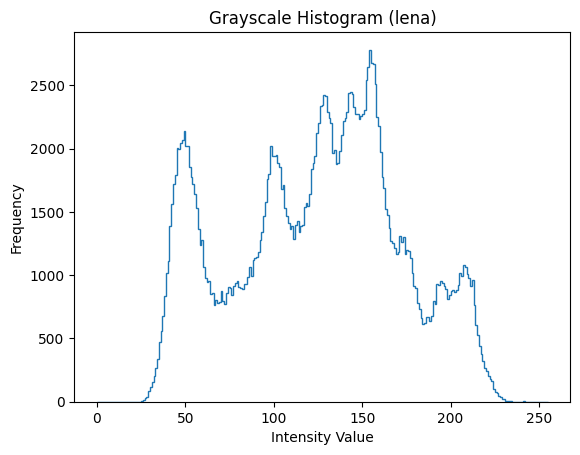

0 255
155 255
0 154
0 255
201 255
0 106
107 200
155 200
107 154
0 255
201 255
0 106
107 200
177 200
107 130
131 176
155 176
131 154
0 255
201 255
0 106
107 200
177 200
107 130
131 176
166 176
131 141
142 165
155 165
142 154
0 255
201 255
0 106
107 200
177 200
107 130
131 176
166 176
131 141
142 165
160 165
142 147
148 159
155 159
148 154


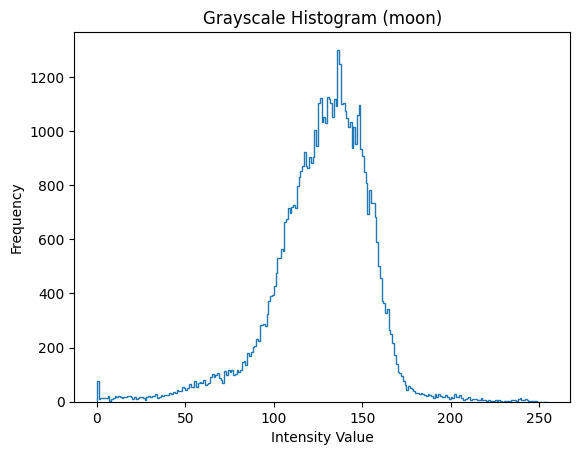

0 255
137 255
0 136
0 255
163 255
0 108
109 162
137 162
109 136
0 255
163 255
0 108
109 162
150 162
109 121
122 149
137 149
122 136
0 255
163 255
0 108
109 162
150 162
109 121
122 149
143 149
122 128
129 142
137 142
129 136
0 255
163 255
0 108
109 162
150 162
109 121
122 149
143 149
122 128
129 142
139 142
129 132
133 138
137 138
133 136


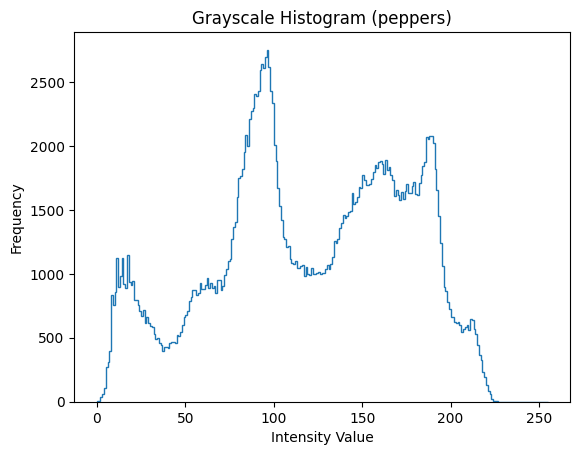

0 255
97 255
0 96
0 255
149 255
0 42
43 148
97 148
43 96
0 255
149 255
0 42
43 148
123 148
43 68
69 122
97 122
69 96
0 255
149 255
0 42
43 148
123 148
43 68
69 122
109 122
69 82
83 108
97 108
83 96
0 255
149 255
0 42
43 148
123 148
43 68
69 122
109 122
69 82
83 108
102 108
83 89
90 101
97 101
90 96


In [ ]:
# Image list
# imlist = ["aerial.tiff"]
imlist = ["aerial.tiff","baboon.tiff","boat.tiff","house.tiff","jet.tiff","lena.tiff","moon.tiff","peppers.tiff"]
# CV2 reads images in BGR and not RGB
# image = cv2.imread('./testimages/lena_std.tif')

# gray = np.mean(image, -1)
# # print(image)
# pre_gray = image * np.array([ 0.114020904255103,0.587043074451121,0.298936021293775])

# gray = np.sum(pre_gray, -1)
# plt.imshow(gray,cmap='gray')
# plt.imsave('./lena.bmp', gray, cmap='gray', format='bmp')

# cv2.imwrite(f"./lena.bmp", gray)
# image2 = plt.imread('./lena.bmp')
# plt.imshow(image2,cmap='gray')


# Calculate the histogram
# hist = cv2.calcHist(gray, [1], None, [256], [0, 256])

# Plot the histogram



for imname in imlist:
    
    image = cv2.imread(f'./testimages/{imname}')
    imname = imname.split(".")[0]

    pre_gray = image * np.array([ 0.114020904255103,0.587043074451121,0.298936021293775])
    
    gray = np.sum(pre_gray, -1)
    
    freq, intensity = np.histogram(gray,range=(0,255),bins=255,density=False)

    plt.figure(imname)
    plt.stairs(freq, intensity)
    plt.xlabel("Intensity Value")
    plt.ylabel("Frequency")
    plt.title(f"Grayscale Histogram ({imname})")
    plt.savefig(f"./test_results/{imname}.png")
    plt.show()
    
    # after plotting adjust the size
    intensity = intensity[:-1]

    for lev in range(2, 12, 2):
        first, last = 0, 255
        a1 = gray
        ths = np.zeros(lev - 1, dtype=int)
        ths_val = np.zeros(lev, dtype=int)
        th_in = 0

        start_time = datetime.now()
        

        for ct in range(lev // 2 - 1):  # execute for lev > 2
            high, low, first, last, a1 = thresh_var(first, last, freq, intensity, a1)
            ths[th_in] = first
            ths[th_in + 1] = last
            ths_val[th_in] = high
            ths_val[th_in + 1] = low
            th_in += 2

        high, low, me, a1 = thresh_mean(first, last, freq, intensity, a1)
        ths[th_in] = me
        ths_val[th_in] = high
        ths_val[th_in + 1] = low

        a2 = a1
        elapsed_time = (datetime.now() - start_time).total_seconds()
        ps = cal_psnr(gray, a1)
        
        cv2.imwrite(f"./test_results/{imname}_{lev}_mode.bmp", a2)
        
        
        write_path = "./"
        outname = f"{imname}_{lev}level.bmp"
        # Image.fromarray(a2).save(os.path.join(write_path, outname))
        # Log to results.txt
        with open(os.path.join(write_path, 'results.txt'), 'a') as f:
            f.write(f"\n\nTime for {outname}: {elapsed_time:.2f} seconds.\n")
            f.write(f"PSNR for {outname}: {ps:.2f} dB.\n")
            f.write(f"Thresholds for {outname}: {' '.join(map(str, sorted(ths_val)))}\n")
            f.write(f"Sub-ranges for {outname}: {' '.join(map(str, sorted(ths)))}\n")

        with open(os.path.join(write_path, 'result_psnr.txt'), 'a') as f:
            f.write(f"\n{outname}\t{ps:.2f}")

        with open(os.path.join(write_path, 'result_cputime.txt'), 'a') as f:
            f.write(f"\n{outname}\t{elapsed_time:.2f}")


# curr_dir = os.getcwd()
# split_dir = curr_dir.split('TheCode')[0]  # same as findstr in MATLAB
# read_path = os.path.join(split_dir, 'testimages')
# write_path = os.path.join(split_dir, 'test_results')
# os.makedirs(write_path, exist_ok=True)

# for imname in imlist:
#     print(f"Processing {imname}")
#     full_path = os.path.join(read_path, imname)
#     img = Image.open(full_path).convert('L')  # grayscale
#     a = np.array(img)
    
#     base_name = os.path.splitext(imname)[0]
#     gray_name = f"{base_name}_gray.bmp"
#     Image.fromarray(a).save(os.path.join(write_path, gray_name))

#     freq, bins = np.histogram(a, bins=256, range=(0, 255+1))  # python doesnt consider last number in range
#     intensity = np.arange(256)

#     for lev in range(2, 13, 2):
#         first, last = 0, 255
#         a1 = a
#         ths = np.zeros(lev - 1, dtype=int)
#         ths_val = np.zeros(lev, dtype=int)
#         th_in = 0

#         start_time = datetime.now()

#         for ct in range(lev // 2 - 1):  # execute for lev > 2
#             high, low, first, last, a1 = thresh_var(first, last, freq, intensity, a1)
#             ths[th_in] = first
#             ths[th_in + 1] = last
#             ths_val[th_in] = high
#             ths_val[th_in + 1] = low
#             th_in += 2

#         high, low, me, a1 = thresh_mean(first, last, freq, intensity, a1)
#         ths[th_in] = me
#         ths_val[th_in] = high
#         ths_val[th_in + 1] = low

#         a2 = a1
#         elapsed_time = (datetime.now() - start_time).total_seconds()
#         ps = cal_psnr(a, a1)

        # outname = f"{base_name}_{lev}level.bmp"
        # Image.fromarray(a2).save(os.path.join(write_path, outname))

        # # Log to results.txt
        # with open(os.path.join(write_path, 'results.txt'), 'a') as f:
        #     f.write(f"\n\nTime for {outname}: {elapsed_time:.2f} seconds.\n")
        #     f.write(f"PSNR for {outname}: {ps:.2f} dB.\n")
        #     f.write(f"Thresholds for {outname}: {' '.join(map(str, sorted(ths_val)))}\n")
        #     f.write(f"Sub-ranges for {outname}: {' '.join(map(str, sorted(ths)))}\n")

        # with open(os.path.join(write_path, 'result_psnr.txt'), 'a') as f:
        #     f.write(f"\n{outname}\t{ps:.2f}")

        # with open(os.path.join(write_path, 'result_cputime.txt'), 'a') as f:
        #     f.write(f"\n{outname}\t{elapsed_time:.2f}")


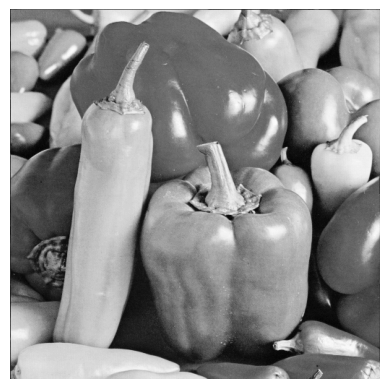

In [21]:
gray2 = np.mean(pre_gray, -1)
plt.axis('off')
plt.imshow(gray2,cmap='gray')